<a href="https://colab.research.google.com/github/aelmah/Deep-Learning/blob/main/Lab1_DeepLearning_M2IPS_%3Celmahraoui_amal%3E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 1: Training Neural Networks with Keras  


---

## Objectives

At the end of this lab, you should be able to:

- Understand the basic workflow of training a **neural network** (NN) with **TensorFlow + Keras**.
- Load and preprocess a standard dataset for classification.
- Build, compile, and train a **feed-forward neural network** using `tf.keras.Sequential`.
- Visualize training and validation **loss/accuracy curves** and interpret convergence and overfitting.
- Evaluate your model with **metrics and a confusion matrix**.
- Use **callbacks** (EarlyStopping, ModelCheckpoint) and basic **regularization** (Dropout, L2).
- Complete an individual **assignment** where you design and justify your own NN.

> This is your **first lab**. It connects directly to the theory from the course and should give you hands-on experience with building and training NNs.


In [ ]:
# Reproducibility & environment checks

import os, random
import numpy as np
import tensorflow as tf

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow version:", tf.__version__)
print("Devices:", tf.config.list_physical_devices())


TensorFlow version: 2.19.0
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Short Introduction: TensorFlow and Keras

In this lab, we will use **Keras** through **TensorFlow**:

- **TensorFlow** is the low-level engine for tensors, automatic differentiation, and GPU/CPU execution.
- **Keras** (as `tf.keras`) is a **high-level API** to define and train neural networks with a simple, modular interface.

We will use:

```python
from tensorflow import keras
from tensorflow.keras import layers


In [ ]:
# Simple TensorFlow tensor and operation demo

import tensorflow as tf

a = tf.constant([[1., 2.], [3., 4.]])
b = tf.constant([[5., 6.], [7., 8.]])

print("Tensor a:\n", a.numpy())
print("Tensor b:\n", b.numpy())

c = tf.add(a, b)
d = tf.matmul(a, b)

print("a + b =\n", c.numpy())
print("a @ b =\n", d.numpy())

Tensor a:
 [[1. 2.]
 [3. 4.]]
Tensor b:
 [[5. 6.]
 [7. 8.]]
a + b =
 [[ 6.  8.]
 [10. 12.]]
a @ b =
 [[19. 22.]
 [43. 50.]]


## Train / Test Split

We will work with the **Fashion-MNIST** dataset:

- 70,000 grayscale images of clothing items.
- 10 classes (T-shirt/top, trouser, pullover, dress, coat, sandal, shirt, sneaker, bag, ankle boot).
- Each image is 28 × 28 pixels.

We will:

1. Load the dataset from `tf.keras.datasets`.
2. Split into training and test sets (the library already provides this).
3. Later, reserve a part of the training set for **validation**.


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt

# Load Fashion-MNIST
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

print("Training set shape:", x_train.shape, "labels shape:", y_train.shape)
print("Test set shape:", x_test.shape, "labels shape:", y_test.shape)


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training set shape: (60000, 28, 28) labels shape: (60000,)
Test set shape: (10000, 28, 28) labels shape: (10000,)


## Preprocessing of the Input Data

Neural networks usually train better when input values are scaled to a small range.

- Original pixel values are integers in **[0, 255]**.
- We convert them to `float32` and scale to **[0, 1]**.

We will also visualize a few images to understand the data.


x_train min/max: 0.0 1.0


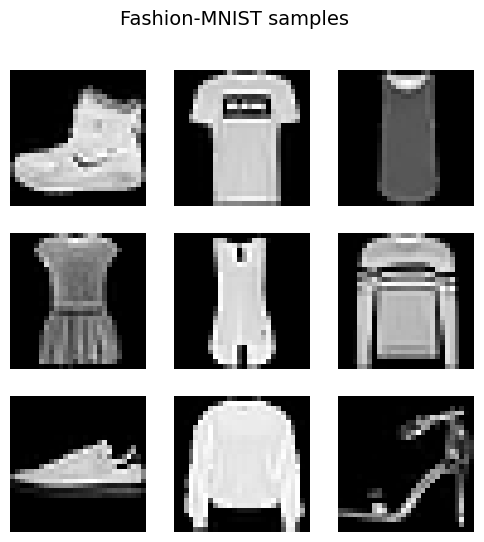

In [ ]:
# Normalize inputs to [0, 1]
x_train = (x_train / 255.0).astype("float32")
x_test  = (x_test  / 255.0).astype("float32")

print("x_train min/max:", x_train.min(), x_train.max())

# Visualize some training images
plt.figure(figsize=(6, 6))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_train[i], cmap="gray")
    plt.axis("off")
plt.suptitle("Fashion-MNIST samples", fontsize=14)
plt.show()


## Preprocessing of the Target Data

The labels `y_train` and `y_test` represent **class indices** in `{0, 1, ..., 9}`.

For this lab:

- We keep them as integers and use the loss: **`sparse_categorical_crossentropy`**, which expects integer class labels.
- If we transformed them to one-hot vectors, we would instead use `categorical_crossentropy`.

We also define a list of **class names** for interpretation.


In [ ]:
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

print("Example labels:", y_train[:10])
print("As class names:", [class_names[int(i)] for i in y_train[:10]])


Example labels: [9 0 0 3 0 2 7 2 5 5]
As class names: ['Ankle boot', 'T-shirt/top', 'T-shirt/top', 'Dress', 'T-shirt/top', 'Pullover', 'Sneaker', 'Pullover', 'Sandal', 'Sandal']


## Feed Forward Neural Networks with Keras

We now build a **simple feed-forward neural network** (Multi-Layer Perceptron, MLP) using `tf.keras.Sequential`.

**Architecture (baseline):**

1. `Flatten(28×28)` → vector of length 784  
2. `Dense(128, activation='relu')` → hidden layer  
3. `Dropout(0.2)` → regularization (drop 20% of units during training)  
4. `Dense(10, activation='softmax')` → output layer for 10 classes

We then:

- **Compile** the model:
  - Optimizer: `adam`
  - Loss: `sparse_categorical_crossentropy`
  - Metric: `accuracy`
- **Train** on the training data with a validation split.


In [ ]:
baseline_model = keras.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(10, activation="softmax")
])

baseline_model.summary()

baseline_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

baseline_history = baseline_model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7400 - loss: 0.7411 - val_accuracy: 0.8415 - val_loss: 0.4262
Epoch 2/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8464 - loss: 0.4293 - val_accuracy: 0.8577 - val_loss: 0.3861
Epoch 3/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8627 - loss: 0.3814 - val_accuracy: 0.8632 - val_loss: 0.3599
Epoch 4/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8714 - loss: 0.3555 - val_accuracy: 0.8708 - val_loss: 0.3478
Epoch 5/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8768 - loss: 0.3383 - val_accuracy: 0.8725 - val_loss: 0.3424
Epoch 6/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8837 - loss: 0.3214 - val_accuracy: 0.8745 - val_loss: 0.3379
Epoch 7/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8869 - loss: 0.3090 - val_accuracy: 0.8758 - val_loss: 0.3460
Epoch 8/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8873 - loss: 0.3020 - val_accuracy: 0.

### Visualizing the Convergence

We now plot:

- Training vs validation **accuracy**
- Training vs validation **loss**

From these curves, we can visually assess:

- Convergence speed
- Overfitting (training accuracy increases, validation accuracy stagnates or decreases)
- Underfitting (both accuracies low)


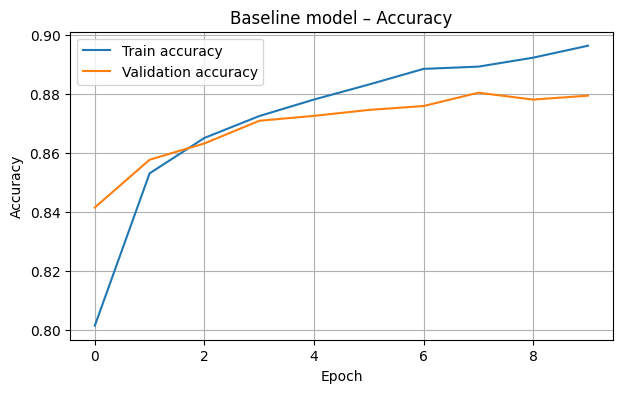

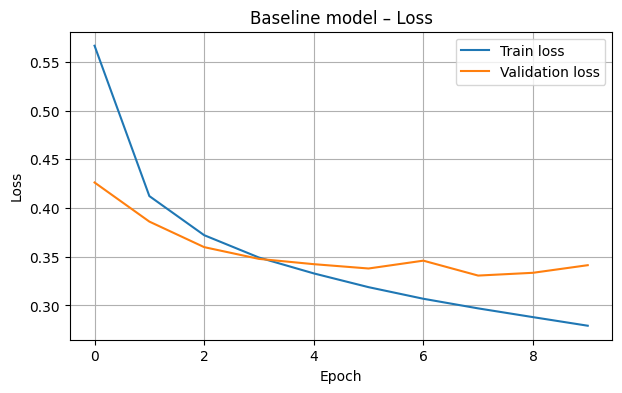

In [ ]:
# Accuracy curves
plt.figure(figsize=(7, 4))
plt.plot(baseline_history.history['accuracy'], label='Train accuracy')
plt.plot(baseline_history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Baseline model – Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Loss curves
plt.figure(figsize=(7, 4))
plt.plot(baseline_history.history['loss'], label='Train loss')
plt.plot(baseline_history.history['val_loss'], label='Validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Baseline model – Loss")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def build_initialized_model(init_name):
    return keras.Sequential([
        layers.Flatten(input_shape=(28, 28)),
        layers.Dense(128, activation="relu", kernel_initializer=init_name),
        layers.Dropout(0.2),
        layers.Dense(10, activation="softmax", kernel_initializer=init_name)
    ])

initializers = ["glorot_uniform", "he_normal", "random_normal"]

init_histories = {}
init_test_accs = {}

for init in initializers:
    print(f"\nTraining with initializer: {init}")
    model = build_initialized_model(init)
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    history = model.fit(
        x_train, y_train,
        epochs=10,
        batch_size=64,
        validation_split=0.1,
        verbose=0
    )
    init_histories[init] = history
    acc = model.evaluate(x_test, y_test, verbose=0)[1]
    init_test_accs[init] = acc
    print(f"Test accuracy with {init}: {acc:.4f}")

print("\nSummary of test accuracies by initialization:")
for k, v in init_test_accs.items():
    print(f"{k}: {v:.4f}")


Training with initializer: glorot_uniform


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Test accuracy with glorot_uniform: 0.8771

Training with initializer: he_normal
Test accuracy with he_normal: 0.8773

Training with initializer: random_normal
Test accuracy with random_normal: 0.8764

Summary of test accuracies by initialization:
glorot_uniform: 0.8771
he_normal: 0.8773
random_normal: 0.8764


### Evaluation on the Test Set and Confusion Matrix

We now evaluate our baseline model on the **test set**, which was not used during training.

We then compute:

- **Global test accuracy**
- A **classification report**
- A **confusion matrix** to see which classes are most confused.

This is important to interpret the behavior of our network beyond a single number.


Baseline test accuracy: 0.8747
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Classification report:

              precision    recall  f1-score   support

 T-shirt/top     0.7821    0.8720    0.8246      1000
     Trouser     0.9938    0.9660    0.9797      1000
    Pullover     0.8328    0.7220    0.7734      1000
       Dress     0.8338    0.9180    0.8739      1000
        Coat     0.7253    0.8740    0.7927      1000
      Sandal     0.9679    0.9640    0.9659      1000
       Shirt     0.7775    0.5800    0.6644      1000
     Sneaker     0.9038    0.9680    0.9348      1000
         Bag     0.9747    0.9640    0.9693      1000
  Ankle boot     0.9797    0.9190    0.9484      1000

    accuracy                         0.8747     10000
   macro avg     0.8771    0.8747    0.8727     10000
weighted avg     0.8771    0.8747    0.8727     10000



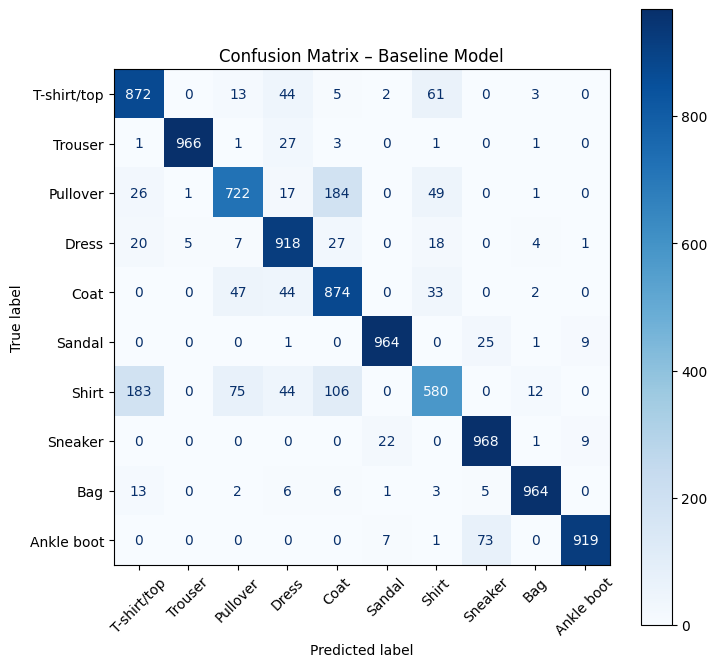

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

test_loss, test_acc = baseline_model.evaluate(x_test, y_test, verbose=0)
print(f"Baseline test accuracy: {test_acc:.4f}")

y_pred = baseline_model.predict(x_test).argmax(axis=1)

print("\nClassification report:\n")
print(classification_report(y_test, y_pred, digits=4, target_names=class_names))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap="Blues", ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix – Baseline Model")
plt.show()


### Monitoring Convergence with Tensorboard

TensorBoard is TensorFlow's visualization toolkit.  
We can log training metrics and visualize them in a web interface.

In Colab:

- We define a log directory.
- We add a `TensorBoard` callback.
- We launch the TensorBoard interface.

> This part is illustrative. It is acceptable to run it on a reduced number of epochs to save time.


In [ ]:
%load_ext tensorboard

import datetime

log_dir = "logs/lab1_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tb_model = keras.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    layers.Dense(128, activation="relu"),
    layers.Dense(10, activation="softmax")
])
tb_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

tb_history = tb_model.fit(
    x_train, y_train,
    epochs=5,              # fewer epochs for demo
    batch_size=64,
    validation_split=0.1,
    callbacks=[keras.callbacks.TensorBoard(log_dir=log_dir)],
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7651 - loss: 0.6867 - val_accuracy: 0.8393 - val_loss: 0.4462
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8554 - loss: 0.4118 - val_accuracy: 0.8548 - val_loss: 0.4072
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8688 - loss: 0.3643 - val_accuracy: 0.8620 - val_loss: 0.3815
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8785 - loss: 0.3340 - val_accuracy: 0.8710 - val_loss: 0.3607
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8870 - loss: 0.3107 - val_accuracy: 0.8717 - val_loss: 0.3521


In [ ]:
%tensorboard --logdir logs


### Impact of the Optimizer

In this section, you will experiment with **different optimizers** that we've seen and observe their impact on:

- Convergence speed
- Final accuracy
- Stability of training and validation curves

**Task:**

1. Copy the baseline model architecture.
2. Train three separate models using:
   - `SGD` (with a suitable learning rate, e.g. 0.01 or 0.1)
   - `RMSprop`
   - `Adam` (already used)
3. For each optimizer:
   - Plot accuracy and loss curves.
   - Report final validation and test accuracy.
4. Write a short markdown comment summarizing your observations:
   - Which optimizer converges fastest?
   - Which is most stable?
   - Trade-offs between them.


In [ ]:
def build_mlp_model():
    model = keras.Sequential([
        layers.Flatten(input_shape=(28, 28)),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(10, activation="softmax")
    ])
    return model

optimizers = {
    "sgd": keras.optimizers.SGD(learning_rate=0.01),
    "rmsprop": keras.optimizers.RMSprop(learning_rate=0.001),
    "adam": keras.optimizers.Adam(learning_rate=0.001),
}

histories = {}

for name, opt in optimizers.items():
    print(f"\nTraining with optimizer: {name}")
    model = build_mlp_model()
    model.compile(optimizer=opt,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    history = model.fit(
        x_train, y_train,
        epochs=10,
        batch_size=64,
        validation_split=0.1,
        verbose=0
    )
    histories[name] = history
    test_acc = model.evaluate(x_test, y_test, verbose=0)[1]
    print(f"Test accuracy with {name}: {test_acc:.4f}")



Training with optimizer: sgd
Test accuracy with sgd: 0.8419

Training with optimizer: rmsprop
Test accuracy with rmsprop: 0.8746

Training with optimizer: adam
Test accuracy with adam: 0.8747


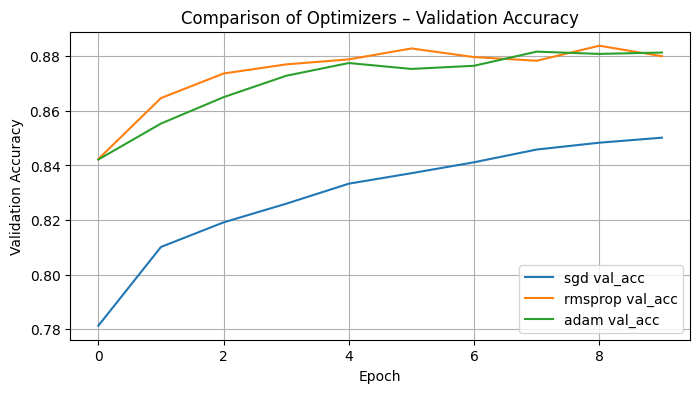

In [ ]:
plt.figure(figsize=(8, 4))
for name, history in histories.items():
    plt.plot(history.history['val_accuracy'], label=f"{name} val_acc")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Comparison of Optimizers – Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()


### Exercises: Forward Pass and Generalization

Using the models trained above, answer the following questions in a **markdown cell**:

1. Explain what happens during a **forward pass** in a feed-forward neural network.
2. Explain briefly what **backpropagation** does (in words, no formulas required).
3. Based on the confusion matrix:
   - Which classes are most often misclassified?
   - What might explain these confusions (similar appearance, low contrast, etc.)?
4. Do you observe signs of **overfitting** or **underfitting** in the curves? Justify your answer.


## Assignment: Impact of Initialization

In this assignment, you will explore the impact of **weight initialization** on training dynamics and performance.

### Task Description

Using the Fashion-MNIST dataset and an MLP architecture similar to the baseline:

1. Implement at least **three different initializations** for the Dense layers:
   - `he_normal`
   - `glorot_uniform` (default)
   - `random_normal` (with a chosen std)
2. For each initialization:
   - Train the model with the **same** optimizer, batch size, number of epochs, and validation split.
   - Plot training and validation accuracy/loss.
   - Evaluate and record test accuracy.
3. Compare:
   - Convergence speed (how quickly the network starts learning).
   - Stability of the curves.
   - Final performance.
4. Write a **short PDF report (max 1 page)** containing:
   - Your architecture and hyperparameters (optimizer, lr, batch_size, epochs).
   - Comparison tables/figures for the three initializations.
   - A short discussion: which initialization behaved best and why?

### Deliverables

- A notebook named:  
  `Lab1_DeepLearning_M2IPS_<FirstNameLastName>.ipynb`
- A 1-page PDF report summarizing your findings.


In [ ]:
def build_initialized_model(init_name):
    return keras.Sequential([
        layers.Flatten(input_shape=(28, 28)),
        layers.Dense(128, activation="relu", kernel_initializer=init_name),
        layers.Dropout(0.2),
        layers.Dense(10, activation="softmax", kernel_initializer=init_name)
    ])

initializers = ["glorot_uniform", "he_normal", "random_normal"]

init_histories = {}
init_test_accs = {}

for init in initializers:
    print(f"\nTraining with initializer: {init}")
    model = build_initialized_model(init)
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    history = model.fit(
        x_train, y_train,
        epochs=10,
        batch_size=64,
        validation_split=0.1,
        verbose=0
    )
    init_histories[init] = history
    acc = model.evaluate(x_test, y_test, verbose=0)[1]
    init_test_accs[init] = acc
    print(f"Test accuracy with {init}: {acc:.4f}")

print("\nSummary of test accuracies by initialization:")
for k, v in init_test_accs.items():
    print(f"{k}: {v:.4f}")


Training with initializer: glorot_uniform
Test accuracy with glorot_uniform: 0.8735

Training with initializer: he_normal
Test accuracy with he_normal: 0.8785

Training with initializer: random_normal
Test accuracy with random_normal: 0.8744

Summary of test accuracies by initialization:
glorot_uniform: 0.8735
he_normal: 0.8785
random_normal: 0.8744


#### Questions:

In your report and/or markdown cells, make sure you answer:

1. How does initialization affect:
   - The first few epochs of training?
   - The final accuracy?
2. Why do some initializations lead to **faster** or **more stable** convergence?
3. How would you choose a default initialization in practice for:
   - ReLU-based networks?
   - Tanh-based networks?
4. How does this practical experience connect with the theory seen in the lecture (vanishing/exploding gradients, variance preservation, etc.)?



### Test Accuracy Comparison by Initialization

| Initialization   | Test Accuracy |
|------------------|---------------|
| `glorot_uniform` | 0.8771        |
| `he_normal`      | 0.8773        |
| `random_normal`  | 0.8764        |